# Given a set of images, upload to DICOM server

For PowerPoint, there's a bit of work. First, save the PPT as JPEG images in a directory, then rename the first 9 to have a leading zero (e.g., Slide1.jpg to Slide01.jpg), otherwise the ordering goes bonkers.  If you have more than 100 slides, then rewrite the code so you don't have to do such crazy renaming for the first 99 images...

In [1]:
import pydicom
from pydicom.dataset import Dataset
from pydicom.sequence import Sequence
from pathlib import Path
from PIL import Image, ImageFilter
import pandas as pd
import requests


In [9]:
# Set variables we're going to use
source_directory_with_images = 'C:\\data\\fakedicom\\images\\'
target_directory_for_dicoms = 'C:\\data\\fakedicom\\files\\'

In [10]:
# define a method to ensure that the number of bytes is even...  that's a DICOMism
def ensure_even(stream):
    # Very important for some viewers
    if len(stream) % 2:
        return stream + b"\x00"
    return stream

In [14]:
# First thing is to encode every image (aka slide) as a dicom file with appropriate metadata
def encode_image_in_dicom(
        ppt_slide_filename, 
        dicom_out_filename, 
        patient_name = 'Anony Mous', 
        study_date = '20200922', 
        studyuid = pydicom.uid.generate_uid(), 
        seriesuid = pydicom.uid.generate_uid(),
        study_id = "1",
        series_number = "1",
        instance_number = "1"
        ):
    # Very simple RGB file
    # Coded version of DICOM file 'C:\githealth\dicom-samples\pydicom_test_files\sc_rgb.dcm'
    # Produced by pydicom codify utility script
    import pydicom
    from pydicom.dataset import Dataset
    from pydicom.sequence import Sequence

    # File meta info data elements
    file_meta = Dataset()
    file_meta.FileMetaInformationGroupLength = 220
    file_meta.FileMetaInformationVersion = b'\x00\x01'
    file_meta.MediaStorageSOPClassUID = '1.2.840.10008.5.1.4.1.1.7'
    file_meta.MediaStorageSOPInstanceUID = '1.2.826.0.1.3680043.8.498.49043964482360854182530167603505525116'
    file_meta.TransferSyntaxUID = '1.2.840.10008.1.2.1'
    file_meta.ImplementationClassUID = '1.2.826.0.1.3680043.8.498.27364069006046809016231924679252811609'

    # Main data elements
    ds = Dataset()
    ds.PatientName = patient_name
    ds.StudyDate = '20200922'
    ds.PatientID = 'Patient0'    
    ds.StudyInstanceUID = studyuid #generate_uid()     
    ds.SeriesInstanceUID = seriesuid
    ds.SeriesNumber = series_number   
    ds.StudyID = study_id
    ds.InstanceNumber = instance_number
    
    ds.SpecificCharacterSet = 'ISO_IR 192'
    ds.ImageType = ['DERIVED', 'SECONDARY', 'OTHER']
    ds.SOPClassUID = '1.2.840.10008.5.1.4.1.1.7'
    ds.SOPInstanceUID = pydicom.uid.generate_uid() #'1.2.826.0.1.3680043.8.498.49043964482360854182530167603505525116'
    ds.ContentDate = ''
    ds.AcquisitionDateTime = ''
    ds.StudyTime = '120000'
    ds.ContentTime = ''
    ds.AccessionNumber = ''
    ds.Modality = 'OT'
    ds.ConversionType = 'SYN'
    ds.ReferringPhysicianName = 'Doctor Dan'
    
    ds.PatientBirthDate = ''
    ds.PatientSex = 'F'
    ds.PatientAge = '024Y'
    ds.PatientPosition = ''


    ds.PatientOrientation = ''
    ds.Laterality = ''
    ds.ImageComments = 'Fake DICOM image'
    ds.SamplesPerPixel = 3
    ds.PhotometricInterpretation = 'RGB'
    ds.PlanarConfiguration = 0
    ds.PixelSpacing = [1.0, 1.0]
    ds.BitsAllocated = 8
    ds.BitsStored = 8
    ds.HighBit = 7
    ds.PixelRepresentation = 0
    ds.SmallestImagePixelValue = 0
    ds.LargestImagePixelValue = 255

    ppt = Image.open(ppt_slide_filename)
    ppt = ppt.convert('RGB')
    ds.PixelData = ensure_even(ppt.tobytes())

    ds.Rows = ppt.height #720
    ds.Columns = ppt.width #1280
    
    ds.file_meta = file_meta
    ds.is_implicit_VR = False
    ds.is_little_endian = True
    ds.save_as(dicom_out_filename, write_like_original=False)
    print(dicom_out_filename)
    return ds

In [15]:
# Convenience cell if you want to generate your own UID for use as a studyuid or seriesuid in code below
pydicom.uid.generate_uid()


'1.2.826.0.1.3680043.8.498.89208737621527345046708178273666177101'

In [20]:
# Create a list of files (aka slides or images as jpg, png, bmp)
# I'm going to just grab everything in a directory that is a jpg and convert them
dirname = source_directory_with_images
files = [x for x in Path(source_directory_with_images).glob('*.png')] 

x = 0
for file in files:
    x = x + 1
    instance_num = str(x)
    print(instance_num)
    image_file = str(file)
    print(image_file)
    dicom_file = f'{source_directory_with_images}{file.stem}.dcm' #just drop into a to_upload folder
    
    # By using the same studyuid and seriesuid, all of them just stack up in a single study and you can scroll through instances
    
    ds = encode_image_in_dicom(image_file,dicom_file,patient_name = "Anony Mous", 
                            studyuid='1.2.826.0.1.3680043.8.498.41962192883955393037793103713413169748',
                            seriesuid='1.2.826.0.1.3680043.8.498.70463000362837156632993179138561697502',
                            series_number="1", instance_number=instance_num)

1
C:\data\fakedicom\images\GreenSquare.png
C:\data\fakedicom\images\GreenSquare.dcm
2
C:\data\fakedicom\images\RedTriangle.png
C:\data\fakedicom\images\RedTriangle.dcm


In [23]:
image_file
ppt = Image.open(image_file)
ppt = ppt.convert('RGB')
#ds.PixelData = ensure_even(ppt.tobytes())

#ds.Rows = ppt.height #720
#ds.Columns = ppt.width #1280


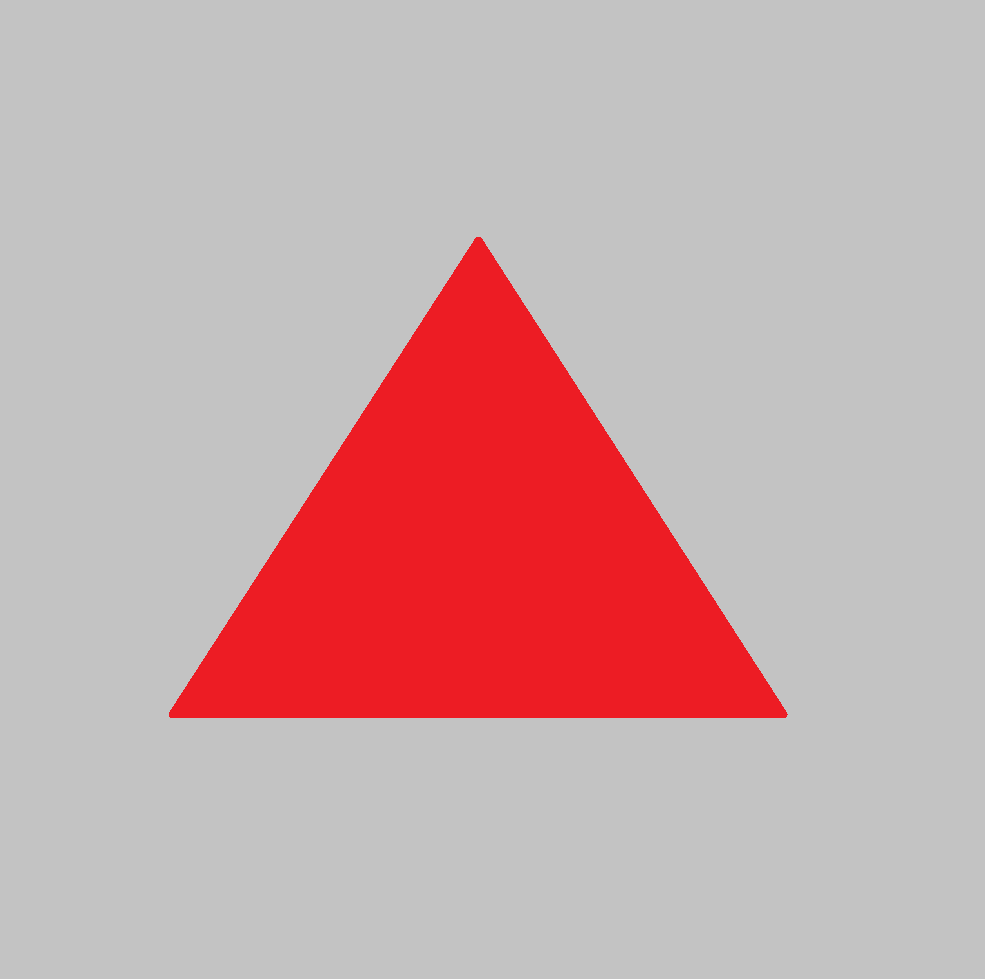

In [24]:
ppt

In [32]:
ds = Dataset()
ds.PixelData = ensure_even(ppt.tobytes())

ds.Rows = ppt.height #720
ds.Columns = ppt.width #1280
print(ds.Columns)
print(ds.Rows)

985
979


## Load preliminary stuff

In [7]:

dicom_server_name = "sjbpostman"
url = f"https://{dicom_server_name}.azurewebsites.net/studies"
url

'https://sjbpostman.azurewebsites.net/studies'

## Grab all DICOM files to upload them

### STOP!!!  Don't forget to rename files in the directory at this point in time.  
TODO: Write python code which does this

In [ ]:
# Rename files to be 

In [8]:

# Can just use this to load all the files in a directory
files = [x for x in Path(target_directory_for_dicoms).glob('*.dcm')] # if not 'pydicom' in str(x)] # exclude pydicom test files
print(len(files))
files.reverse() # This puts them in order in the viewer, since by default it's last in first viewed


64


## Upload the files

In [9]:
from urllib3.filepost import encode_multipart_formdata, choose_boundary

def encode_multipart_related(fields, boundary=None):
    if boundary is None:
        boundary = choose_boundary()

    body, _ = encode_multipart_formdata(fields, boundary)
    content_type = str('multipart/related; boundary=%s' % boundary)

    return body, content_type

In [10]:
def upload_single_dcm_file(server_url,filepath):
    with open(filepath,'rb') as reader:
        rawfile = reader.read()
    files = {'file': ('dicomfile', rawfile, 'application/dicom')}

    #encode as multipart_related
    body, content_type = encode_multipart_related(fields = files)
    
    headers = {'Accept':'application/dicom+json', "Content-Type":content_type}

    response = requests.post(url, body, headers=headers) #, verify=False)
    
    #return the response object to allow for further processing
    
    #example usage
    #r = upload_single_dcm_file(url,'C:\\githealth\\dicom-samples\\visus.com\\case4\\case4a_002.dcm')
    #print(r.status_code)
    #print(r.request.headers)
    
    return response

In [11]:
# Not necessary, but it gives some idea of whether things uploaded properly and allows troubleshooting
from collections import OrderedDict
def store_files_to_dicomweb_with_logging_to_dataframe(filepaths, df = None):
    if df is None:
        # Then we have a blank dataframe, maybe do something here.
        #   for now, I'm just using a blank one.
        #columns = ['fname','status_code','response_notes']
        df = pd.DataFrame()
        df['fname']=filepaths
    
    # Fastest to just use lists and dictionaries then create a new dataframe from that...
    numfiles=len(filepaths)
    current_count=0
    
    files_info = []
    for file in filepaths:
        print(f'Uploading {str(file)}')
        # Upload a single file at a time (and time it)
        r = upload_single_dcm_file(url,file)     # call API and get response 
        d = OrderedDict()   # create a new ordered dictionary
        
        # Add the information to the dictionary
        d['fname'] = str(file)     
        d['method'] = r.request.method
        d['url'] = r.url
        d['path_url'] = r.request.path_url
        d['request_headers'] = str(r.request.headers)
        d['request_body_trimmed'] = r.request.body[0:150]   

        d['ok'] = r.ok
        d['status_code'] = r.status_code  
        d['reason'] = r.reason
        d['response_headers'] = r.headers
        d['response_text'] = r.text  
        d['elapsed_time'] = r.elapsed
        d['apparent_encoding'] = r.apparent_encoding
        d['encoding'] = r.encoding
        
 
        files_info.append(d)
        current_count += 1
        if current_count%250==0:
            print(f"{current_count} of {numfiles} uploaded")

    # Create a dataframe from the uploads
    df = pd.DataFrame(files_info)               
    return df
        
    
    

In [12]:
df = store_files_to_dicomweb_with_logging_to_dataframe(files)

Uploading C:\data\to_upload\Slide9.dcm
Uploading C:\data\to_upload\Slide8.dcm
Uploading C:\data\to_upload\Slide7.dcm
Uploading C:\data\to_upload\Slide6.dcm
Uploading C:\data\to_upload\Slide56.dcm
Uploading C:\data\to_upload\Slide55.dcm
Uploading C:\data\to_upload\Slide54.dcm
Uploading C:\data\to_upload\Slide53.dcm
Uploading C:\data\to_upload\Slide52.dcm
Uploading C:\data\to_upload\Slide51.dcm
Uploading C:\data\to_upload\Slide50.dcm
Uploading C:\data\to_upload\Slide5.dcm
Uploading C:\data\to_upload\Slide49.dcm
Uploading C:\data\to_upload\Slide48.dcm
Uploading C:\data\to_upload\Slide47.dcm
Uploading C:\data\to_upload\Slide46.dcm
Uploading C:\data\to_upload\Slide44.dcm
Uploading C:\data\to_upload\Slide43.dcm
Uploading C:\data\to_upload\Slide42.dcm
Uploading C:\data\to_upload\Slide41.dcm
Uploading C:\data\to_upload\Slide40.dcm
Uploading C:\data\to_upload\Slide4.dcm
Uploading C:\data\to_upload\Slide39.dcm
Uploading C:\data\to_upload\Slide38.dcm
Uploading C:\data\to_upload\Slide37.dcm
Upload

In [13]:
# Use the status_code column to determine successful upload
df.head(10)

,fname,method,url,path_url,request_headers,request_body_trimmed,ok,status_code,reason,response_headers,response_text,elapsed_time,apparent_encoding,encoding
0,C:\data\to_upload\Slide9.dcm,POST,https://sjbdicom2.azurewebsites.net/studies,/studies,"{'User-Agent': 'python-requests/2.23.0', 'Acce...",b'--c097db2e351b3ec3426cf672212f4495\r\nConten...,False,409,Conflict,"[Content-Length, Content-Type, Server, Request...","{""00081198"":{""vr"":""SQ"",""Value"":[{""00081150"":{""...",00:00:00.534516,ascii,utf-8
1,C:\data\to_upload\Slide8.dcm,POST,https://sjbdicom2.azurewebsites.net/studies,/studies,"{'User-Agent': 'python-requests/2.23.0', 'Acce...",b'--979de354ecdc64f690ad8e6e5cec9155\r\nConten...,False,409,Conflict,"[Content-Length, Content-Type, Server, Request...","{""00081198"":{""vr"":""SQ"",""Value"":[{""00081150"":{""...",00:00:00.320071,ascii,utf-8
2,C:\data\to_upload\Slide7.dcm,POST,https://sjbdicom2.azurewebsites.net/studies,/studies,"{'User-Agent': 'python-requests/2.23.0', 'Acce...",b'--04f6412adcd45ac0d08d71a586a628bf\r\nConten...,False,409,Conflict,"[Content-Length, Content-Type, Server, Request...","{""00081198"":{""vr"":""SQ"",""Value"":[{""00081150"":{""...",00:00:00.260731,ascii,utf-8
3,C:\data\to_upload\Slide6.dcm,POST,https://sjbdicom2.azurewebsites.net/studies,/studies,"{'User-Agent': 'python-requests/2.23.0', 'Acce...",b'--03bd569cf1228a574de3f0e658fdc816\r\nConten...,False,409,Conflict,"[Content-Length, Content-Type, Server, Request...","{""00081198"":{""vr"":""SQ"",""Value"":[{""00081150"":{""...",00:00:00.303672,ascii,utf-8
4,C:\data\to_upload\Slide56.dcm,POST,https://sjbdicom2.azurewebsites.net/studies,/studies,"{'User-Agent': 'python-requests/2.23.0', 'Acce...",b'--5910ec11a2ab1c5374d76d4bba94ec0b\r\nConten...,False,409,Conflict,"[Content-Length, Content-Type, Server, Request...","{""00081198"":{""vr"":""SQ"",""Value"":[{""00081150"":{""...",00:00:00.330942,ascii,utf-8
5,C:\data\to_upload\Slide55.dcm,POST,https://sjbdicom2.azurewebsites.net/studies,/studies,"{'User-Agent': 'python-requests/2.23.0', 'Acce...",b'--355168c8aa822c179d6c9cb06d073394\r\nConten...,False,409,Conflict,"[Content-Length, Content-Type, Server, Request...","{""00081198"":{""vr"":""SQ"",""Value"":[{""00081150"":{""...",00:00:00.286439,ascii,utf-8
6,C:\data\to_upload\Slide54.dcm,POST,https://sjbdicom2.azurewebsites.net/studies,/studies,"{'User-Agent': 'python-requests/2.23.0', 'Acce...",b'--a0963dd6b48f015264ce671131066210\r\nConten...,False,409,Conflict,"[Content-Length, Content-Type, Server, Request...","{""00081198"":{""vr"":""SQ"",""Value"":[{""00081150"":{""...",00:00:00.272476,ascii,utf-8
7,C:\data\to_upload\Slide53.dcm,POST,https://sjbdicom2.azurewebsites.net/studies,/studies,"{'User-Agent': 'python-requests/2.23.0', 'Acce...",b'--e47d25fc06957e5dc5e162acc434c441\r\nConten...,False,409,Conflict,"[Content-Length, Content-Type, Server, Request...","{""00081198"":{""vr"":""SQ"",""Value"":[{""00081150"":{""...",00:00:00.251859,ascii,utf-8
8,C:\data\to_upload\Slide52.dcm,POST,https://sjbdicom2.azurewebsites.net/studies,/studies,"{'User-Agent': 'python-requests/2.23.0', 'Acce...",b'--e27f77e6e91d0f704f9baf2906909b6e\r\nConten...,False,409,Conflict,"[Content-Length, Content-Type, Server, Request...","{""00081198"":{""vr"":""SQ"",""Value"":[{""00081150"":{""...",00:00:00.308269,ascii,utf-8
9,C:\data\to_upload\Slide51.dcm,POST,https://sjbdicom2.azurewebsites.net/studies,/studies,"{'User-Agent': 'python-requests/2.23.0', 'Acce...",b'--46be8e056da786b315bbb3a5b436ed33\r\nConten...,False,409,Conflict,"[Content-Length, Content-Type, Server, Request...","{""00081198"":{""vr"":""SQ"",""Value"":[{""00081150"":{""...",00:00:00.287855,ascii,utf-8


In [41]:
pydicom.uid.generate_uid()

'1.2.826.0.1.3680043.8.498.77033797676425927098669402985243398207'

## This just uploads a single file, as an example

In [42]:
# Very simple RGB file
# Coded version of DICOM file 'C:\githealth\dicom-samples\pydicom_test_files\sc_rgb.dcm'
# Produced by pydicom codify utility script
import pydicom
from pydicom.dataset import Dataset
from pydicom.sequence import Sequence

# File meta info data elements
file_meta = Dataset()
file_meta.FileMetaInformationGroupLength = 220
file_meta.FileMetaInformationVersion = b'\x00\x01'
file_meta.MediaStorageSOPClassUID = '1.2.840.10008.5.1.4.1.1.7'
file_meta.MediaStorageSOPInstanceUID = '1.2.826.0.1.3680043.8.498.49043964482360854182530167603505525116'
file_meta.TransferSyntaxUID = '1.2.840.10008.1.2.1'
file_meta.ImplementationClassUID = '1.2.826.0.1.3680043.8.498.27364069006046809016231924679252811609'

# Main data elements
ds = Dataset()
ds.SpecificCharacterSet = 'ISO_IR 192'
ds.ImageType = ['DERIVED', 'SECONDARY', 'OTHER']
ds.SOPClassUID = '1.2.840.10008.5.1.4.1.1.7'
ds.SOPInstanceUID = pydicom.uid.generate_uid()
ds.StudyDate = '20200922'
ds.ContentDate = ''
ds.AcquisitionDateTime = ''
ds.StudyTime = '120000'
ds.ContentTime = ''
ds.AccessionNumber = ''
ds.Modality = 'OT'
ds.ConversionType = 'SYN'
ds.ReferringPhysicianName = 'Doctor Doc'
ds.PatientName = 'Anony Mous'
ds.PatientID = 'ID1'
ds.PatientBirthDate = ''
ds.PatientSex = 'F'
ds.PatientAge = '024Y'
ds.PatientPosition = ''
ds.StudyInstanceUID = '1.2.826.0.1.3680043.8.498.13230779778012324449356534479549187420' #generate_uid()
ds.SeriesInstanceUID = '1.2.826.0.1.3680043.8.498.77033797676425927098669402985243398207' #generate_uid()
ds.StudyID = '1'
ds.SeriesNumber = "2"
ds.InstanceNumber = "1"
ds.PatientOrientation = ''
ds.Laterality = ''
ds.ImageComments = 'Fake DICOM - Blue Circle'
ds.SamplesPerPixel = 3
ds.PhotometricInterpretation = 'RGB'
ds.PlanarConfiguration = 0
ds.Rows = 979
ds.Columns = 985
ds.PixelSpacing = [1.0, 1.0]
ds.BitsAllocated = 8
ds.BitsStored = 8
ds.HighBit = 7
ds.PixelRepresentation = 0
ds.SmallestImagePixelValue = 0
ds.LargestImagePixelValue = 255

ppt = Image.open(r'C:\data\fakedicom\images\BlueCircle.png')
#ppt = Image.open(r'C:\data\fakedicom\images\RedTriangle.png')
#ppt = Image.open(r'C:\data\fakedicom\images\GreenSquare.png')
ppt = ppt.convert('RGB')
ds.PixelData = ensure_even(ppt.tobytes())

#ds.PixelData = # XXX Array of 30000 bytes excluded

ds.file_meta = file_meta
ds.is_implicit_VR = False
ds.is_little_endian = True
ds.save_as(r'C:\data\fakedicom\files\BlueCircle.dcm', write_like_original=False)
#ds.save_as(r'C:\data\fakedicom\files\RedTriangle.dcm', write_like_original=False)
#ds.save_as(r'C:\data\fakedicom\files\GreenSquare.dcm', write_like_original=False)